### Test inputs

In [22]:
inputs = [
    '..@@.@@@@.',
    '@@@.@.@.@@',
    '@@@@@.@.@@',
    '@.@@@@..@.',
    '@@.@@@@.@@',
    '.@@@@@@@.@',
    '.@.@.@.@@@',
    '@.@@@.@@@@',
    '.@@@@@@@@.',
    '@.@.@@@.@.'
]

## Task 2

In [ ]:
def read_input():
    with open("input", "r") as f:
        data = [line.strip() for line in f.readlines()]

    if len(data) == 1:
        return data[0]
    else:
        return data


inputs2 = read_input()

## Sum matrix solution

In [25]:
import numpy as np
import time
import matplotlib.pyplot as plt

ijs = [
    (i - 1, j - 1)
    for i in range(3)
    for j in range(3)
    if not (i == 1 and j == 1)
]


def create_sum_array(index_grid):
    sum_array = np.zeros_like(index_grid)
    for i, j in ijs:
        sum_array += np.roll(index_grid, (i, j), axis=(0, 1))
    return sum_array


def solve_gold(inputs):
    map = {"@": 1, ".": 0}
    index_grid = np.array([[map[ch] for ch in input] for input in inputs])
    index_grid = np.pad(index_grid, 1)

    total_papers = 0
    counter = 10
    while counter > 0:
        sum_array = create_sum_array(index_grid)

        # Multiply
        grid = index_grid * sum_array

        # Mask of items to remove
        mask = (index_grid[1:-1, 1:-1] == 1) & (grid[1:-1, 1:-1] < 4)
        counter = mask.sum()

        # Remove these papers
        index_grid[1:-1, 1:-1] = np.where(mask, 0, index_grid[1:-1, 1:-1])
        total_papers += counter
    return total_papers

## Sum-Matrix (Indexing trick)

In [26]:
def solve_gold_indexing(inputs):
    map = {"@": 1, ".": 0}
    index_grid = np.pad(
        np.array([[map[ch] for ch in input] for input in inputs]),
        1
    )

    total_papers = 0
    m, n = index_grid.shape
    while True:
        neighbours = np.sum(
            np.stack(
                [
                    index_grid[
                        offset_i:m - (2 - offset_i),
                        offset_j:n - (2 - offset_j)
                    ]
                    for offset_i in range(3)
                    for offset_j in range(3)
                ]
            ), axis=0
        )

        mask = neighbours < 4
        removed = (mask * index_grid[1:-1, 1:-1]).sum()

        if removed == 0:
            break

        total_papers += removed
        index_grid[1:-1, 1:-1] *= ~mask

    return total_papers

## Convolution

In [27]:
from scipy.signal import convolve2d


def solve_gold_conv(inputs):
    map = {"@": 1, ".": 0}
    index_grid = np.array([[map[ch] for ch in input] for input in inputs])
    index_grid = np.pad(index_grid, 1)

    kernel = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ])

    total_papers = 0
    counter = 10
    while counter > 0:

        grid = convolve2d(index_grid[1:-1, 1:-1], kernel)

        mask = (index_grid[1:-1, 1:-1] == 1) & (grid[1:-1, 1:-1] < 4)
        counter = mask.sum()

        # Remove these papers
        index_grid[1:-1, 1:-1] = np.where(mask, 0, index_grid[1:-1, 1:-1])
        total_papers += counter
    return total_papers

## Benchmark

Benchmarking size: 5x5
237 μs ± 22.9 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
49.7 μs ± 7.85 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
88 μs ± 17.6 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
Benchmarking size: 10x10
290 μs ± 47.1 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
84.8 μs ± 10.6 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
92.5 μs ± 8.69 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
Benchmarking size: 20x20
510 μs ± 38.1 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
239 μs ± 48.5 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
223 μs ± 39.6 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
Benchmarking size: 50x50
1.32 ms ± 259 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
1.03 ms ± 64.4 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
485 μs ± 36.1 μs per loop (mean ± std. dev. of 7 runs, 20 loops each)
Benchmarking size: 100x100
2.16 ms ± 165 μs per loop (mean 

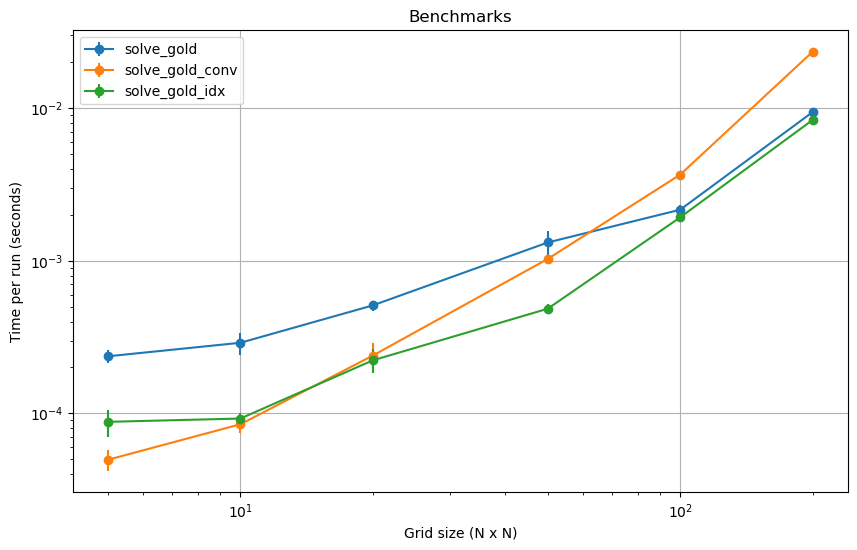

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time

def random_input(n, m):
    """Generate an nxm random grid of '.' and '@'."""
    chars = np.array(['.', '@'])
    return [''.join(np.random.choice(chars, m)) for _ in range(n)]

# grid sizes
sizes = [5, 10, 20, 50, 100, 200]   
gold_means = []
gold_stds = []
conv_means = []
conv_stds = []
idx_means = []
idx_stds = []

for n in sizes:
    print(f"Benchmarking size: {n}x{n}")
    inp = random_input(n, n)

    # ---- solve_gold ----
    t_gold = %timeit -o -n20 solve_gold(inp)
    gold_means.append(t_gold.average)
    gold_stds.append(t_gold.stdev)

    # ---- solve_gold_conv ----
    t_conv = %timeit -o -n20 solve_gold_conv(inp)
    conv_means.append(t_conv.average)
    conv_stds.append(t_conv.stdev)

    # ---- solve_gold_idx ----
    t_idx = %timeit -o -n20 solve_gold_indexing(inp)
    idx_means.append(t_idx.average)
    idx_stds.append(t_idx.stdev)

#  PLOT RESULTS

plt.figure(figsize=(10,6))
plt.errorbar(
    sizes, gold_means, yerr=gold_stds, marker='o', label="solve_gold")
plt.errorbar(
    sizes, conv_means, yerr=conv_stds, marker='o', label="solve_gold_conv")
plt.errorbar(
    sizes, idx_means, yerr=idx_stds, marker='o', label="solve_gold_idx")

plt.xlabel("Grid size (N x N)")
plt.ylabel("Time per run (seconds)")
plt.title("Benchmarks")
plt.grid(True)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()
